[URL dashboard](https://public.tableau.com/app/profile/jason.rich.darmawan/viz/h8dsft_Milestone1_jason_rich_darmawan_onggo_putra/StorytellingTime?publish=yes)

# Perkenalan

Nama : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

# Identifikasi Masalah

## Topik Permasalahan

Perbandingan Pembelian Alkohol di Iowa, Amerika Serikat sebelum Pandemi Covid-19 dan puncak (kasus baru per hari) Pandemi Covid-19

Data sebelum Pandemi Covid-19 yang digunakan adalah bulan Januari 2018.

Data Puncak Pandemi Covid-19 yang digunakan adalah bulan Januari 2021.

## Problem Statement

Mengetahui Kota, Ukuran Botol, Kategori Minuman Beralkohol yang harus distok dan potensi nilai pasar yang dilayani ketika terjadi krisis.

## Latar Belakang

Sebagai Data Analyst yang mungkin akan bekerja di e-commerce atau franchisor convenience store, saya perlu intuisi untuk "apa yang harus dilakukan ketika terjadi krisis seperti Pandemi Covid-19", "berapa nilai GMV minuman beralkohol jika membuka toko di kota Top 1, dengan ukuran botol Top 1-5, dan kategori minuman beralkohol Top 1-5"

## Penjabaran Masalah

### Visualisasi

Tujuan: mencari kota terbaik untuk menjual minuman beralkohol

- [x] Di kota (column `city`) mana penjualan tertinggi (dalam volume / column `volume_sold_liters`) minuman beralkohol di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?
- [x] Di kota (column `city`) mana penjualan tertinggi (dalam total harga / column `sale_dollars`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?

Tujuan: menentukan ukuran botol dan kategori minuman beralkohol yang harus distok

- [x] Apa ukuran botol (column `bottle_volume_ml`) minuman beralkohol yang paling banyak terjual (column `bottles_sold`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?
- [x] Apa kategori (column `category_name`) minuman beralkohol yang paling banyak terjual (column `bottles_sold`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?

### Statistik Deskriptif

Tujuan: membuat promo **Min. Jumlah Volume** dan **Min. Belanja**

- [x] Berapa rata-rata penjualan minuman beralkohol (dalam volume / column `volume_sold_liters`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?
- [x] Berapa rata-rata penjualan minuman beralkohol (dalam total harga / column `sale_dollars`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?

Tujuan: mengetahui nilai GMV minuman beralkohol di Iowa, Amerika Serikat

- [x] Berapa GMV minuman beralkohol di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022?

### Hypothesis Testing 1

- [x] Apa rata-rata penjualan minuman beralkohol (dalam volume / column `volume_sold_liters`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022 sama/berbeda (lebih kecil/lebih besar)?
- [x] Apa rata-rata penjualan minuman beralkohol (dalam total harga / column `sale_dollars`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022 sama/berbeda?

### Hypothesis Testing 2

- [x] Apa rata-rata harga minuman beralkohol (column `state_bottle_retail`) di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022 sama/berbeda?

# Data Loading

## Import Library

In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# fix plotly is not showing in github.
# if you want to have interactive plotly, use `fig.show("notebook_connected")`
import plotly.io as pio
pio.renderers.default = "svg"

from scipy import stats

## Reference

project: bigquery-public-data

dataset: iowa_liquor_sales

table: sales

## Query

advantage: sub-query agar lebih clean dan lebih mudah ganti tahun dan bulan.

disadvantage: result sub-query-nya boros (diload hanya untuk difilter di query berikutnya).

```
SELECT *,
FROM (
  SELECT *, 
         EXTRACT(YEAR FROM date) as year,
         EXTRACT(MONTH FROM date) as month
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE date BETWEEN "2018-01-01" AND "2022-01-31"
)
WHERE year IN (2018, 2022) 
 AND month=1
```

In [2]:
df = pd.read_csv("./bigquery-public-data_iowa_liquor_sales_year_2018_and_year_2022_month_1.csv")

## DataFrame.head()

drop columns
- [x] can't be visualized nor answer 'Penjabaran Masalah'
  `store_number`, `store_name`, `address`, `store_location`, `vendor_number`, `vendor_name`, `item_number`, `item_description`
- too big to derive conclusion from
  `county_number`, `county`
- duplicated columns
  `volume_sold_gallons`

DataFrame.sort_values() 
- [x] by column `date`

In [3]:
pd.options.display.max_columns = None
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month
0,INV-10095200050,2018-01-30,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001.0,POINT (-90.668138 42.504959),31.0,DUBUQUE,1092100.0,Imported Distilled Spirit Specialty,55.0,SAZERAC NORTH AMERICA,76227,Montezuma Blue,12,1000,4.66,6.99,60,419.40,60.00,15.85,2018,1
1,INV-09780600017,2018-01-15,4669,Vom Fass / Des Moines,"833, 42nd St",Des Moines,50312.0,POINT (-93.674384 41.59343100000001),77.0,POLK,1901200.0,Special Order Items,885.0,YAHARA BAY DISTILLERS INC,905081,Yahara Bay Apple Crisp(Apple Pie),6,200,7.98,11.97,6,71.82,1.20,0.32,2018,1
2,INV-43674300036,2022-01-11,4843,Stewart Road Fast Break,2418 Stewart Rd,Muscatine,52761.0,POINT (-91.072733 41.390826),70.0,MUSCATINE,1091300.0,Neutral Grain Spirits Flavored,346.0,OLE SMOKY DISTILLERY LLC,86739,Ole Smoky Apple Pie Moonshine 70prf Mini,8,50,8.75,13.13,3,39.39,0.15,0.03,2022,1
3,INV-43538900011,2022-01-05,5750,Casey's General Store #2920 / Ankeny,1010 SE National Dr,Ankeny,50021.0,POINT (-93.582179 41.70486400000001),77.0,POLK,1091300.0,Neutral Grain Spirits Flavored,346.0,OLE SMOKY DISTILLERY LLC,986845,SOOH Ole Smoky Blackberry Moonshine Mini,8,50,8.75,13.13,4,52.52,0.20,0.05,2022,1
4,INV-43515200004,2022-01-04,9047,Revelton Distilling Company,1400 W Clay St,Osceola,50213.0,POINT (-93.787233 41.041472),20.0,CLARKE,1011700.0,Corn Whiskies,654.0,Revelton Distilling Company,26294,Revelton Shine White Whiskey Mini,6,50,14.40,21.60,6,129.60,0.30,0.07,2022,1


In [4]:
# Is column invoice_and_item_number value unique?
df.loc[df['invoice_and_item_number'].map(df['invoice_and_item_number'].value_counts()) > 1]
# alternative method:
# df.loc[df['invoice_and_item_number'].duplicated()]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month


## DataFrame.columns

In [5]:
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'year',
       'month'],
      dtype='object')

## Column `category_name` Values

In [6]:
df['category'].value_counts().index

Float64Index([1031100.0, 1012100.0, 1011200.0, 1081600.0, 1062400.0, 1031200.0,
              1011100.0, 1081400.0, 1051100.0, 1032100.0, 1022200.0, 1011400.0,
              1081200.0, 1081300.0, 1071100.0, 1062200.0, 1062500.0, 1082000.0,
              1022100.0, 1032200.0, 1082200.0, 1041100.0, 1012200.0, 1052100.0,
              1701100.0, 1012400.0, 1042100.0, 1012300.0, 1011600.0, 1081100.0,
              1062100.0, 1091300.0, 1062300.0, 1081500.0, 1091100.0, 1011300.0,
              1091200.0, 1011500.0, 1901200.0, 1092100.0, 1082100.0, 1011700.0,
              1700000.0, 1041200.0, 1022300.0, 1041300.0, 1091400.0, 1031000.0,
              1090000.0, 1091000.0, 1092000.0, 1042000.0, 1032000.0, 1070000.0,
              1081000.0],
             dtype='float64')

## Column `city` Values

In [7]:
df['city'].value_counts().index

Index(['Des Moines', 'Cedar Rapids', 'Davenport', 'Waterloo', 'Sioux City',
       'West Des Moines', 'Ames', 'Council Bluffs', 'Dubuque', 'Iowa City',
       ...
       'Casey', 'Roland', 'Ossian', 'Melbourne', 'Bussey', 'Stanwood',
       'Fontanelle', 'Blairstown', 'Earling', 'Colorado Springs'],
      dtype='object', length=444)

## Column `bottle_volume_ml` Values

In [8]:
df['bottle_volume_ml'].value_counts().index.sort_values()

Int64Index([  20,   50,  100,  200,  300,  375,  400,  500,  600,  700,  750,
             800,  850,  900,  950, 1000, 1200, 1750, 1800, 1950, 2250, 2400,
            3000, 3500, 4500, 5250, 6000],
           dtype='int64')

## DataFrame.describe()

detecting and treating outliers on columns

- [x] year 2018
  - columns 'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters'
- [x] year 2022
  - columns 'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters'

In [9]:
def calculateLowerLimitUpperLimit(series: pd.Series):
    skew = series.skew()

    # extreme skewed distribution
    if skew < -1 or skew > 1:
        q1, q3 = series.quantile([.25,.75])
        iqr = q3 - q1
        return q1 - iqr * 3, q3 + iqr * 3
        
    # skewed distribution
    elif skew < -0.5 or skew > 0.5:
        q1, q3 = series.quantile([.25,.75])
        iqr = q3 - q1
        return q1 - iqr * 1.5, q3 + iqr * 1.5

    # normal distribution
    else:
        mean, std = series.agg(['mean', 'std'])
        return mean - 3 * std, mean + 3 * std

def detect_lower_limit_min_upper_limit_max():
    for year in [2018, 2022]:
        for index, value in df.loc[(df['year'] == year) & (df['month'] == 1), 
                                   ['pack', 'bottle_volume_ml', 'state_bottle_cost', 
                                    'state_bottle_retail', 'bottles_sold', 'sale_dollars', 
                                    'volume_sold_liters']] \
                              .items():
            lowerLimit, upperLimit = calculateLowerLimitUpperLimit(value)

            min, max = value.agg(['min', 'max'])
            if lowerLimit > min or upperLimit < max:
                print("year {0}, column {1}, lower limit {2}, min {3}, upper limit {4}, max {5}" \
                      .format(year, index, lowerLimit, min, upperLimit, max))

detect_lower_limit_min_upper_limit_max()

year 2018, column pack, lower limit -12.0, min 1, upper limit 30.0, max 48
year 2018, column bottle_volume_ml, lower limit 0.0, min 50, upper limit 1750.0, max 6000
year 2018, column state_bottle_cost, lower limit -15.069999999999997, min 0.89, upper limit 32.879999999999995, max 1599.19
year 2018, column state_bottle_retail, lower limit -22.619999999999997, min 1.34, upper limit 49.339999999999996, max 2398.79
year 2018, column bottles_sold, lower limit -28.0, min 1, upper limit 42.0, max 1980
year 2018, column sale_dollars, lower limit -285.0, min 0.0, upper limit 450.0, max 36154.8
year 2018, column volume_sold_liters, lower limit -25.5, min 0.05, upper limit 37.5, max 2100.0
year 2022, column pack, lower limit -12.0, min 1, upper limit 30.0, max 60
year 2022, column bottle_volume_ml, lower limit -562.5, min 20, upper limit 1937.5, max 5250
year 2022, column state_bottle_cost, lower limit -18.28, min 0.89, upper limit 38.21, max 1949.02
year 2022, column state_bottle_retail, lower l

## DataFrame.info()

handle null rows on columns

range index: 373231 entries
- [x] remove null due to categorical data
  - `city`            372256
  - `zip_code`        372256
  - `category`        373094
  - `category_name`   373094

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373231 entries, 0 to 373230
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   invoice_and_item_number  373231 non-null  object 
 1   date                     373231 non-null  object 
 2   store_number             373231 non-null  int64  
 3   store_name               373231 non-null  object 
 4   address                  372256 non-null  object 
 5   city                     372256 non-null  object 
 6   zip_code                 372256 non-null  float64
 7   store_location           335493 non-null  object 
 8   county_number            372254 non-null  float64
 9   county                   372256 non-null  object 
 10  category                 373094 non-null  float64
 11  category_name            373094 non-null  object 
 12  vendor_number            373231 non-null  float64
 13  vendor_name              373231 non-null  object 
 14  item

# Data Cleaning

In [11]:
df2 = df.sort_values('date').reset_index(drop=True).copy()

In [12]:
df3 = df2.drop(['store_number', 'store_name', 'address', 'store_location', 
                'vendor_number', 'vendor_name', 'item_number', 'item_description', 
                'county_number', 'county', 'volume_sold_gallons'], 
                axis='columns') \
         .copy()

## Outliers Detection and Treatment

In [13]:
def detectOutliers(series: pd.Series, year: int):
    lowerLimit, upperLimit = calculateLowerLimitUpperLimit(series)
    outliersPercentage = len(series.loc[(series < lowerLimit) | (series > upperLimit)]) \
                        / len(series)
    print("year {0}, column {1}, skew {2:.2f}, outliers percentage {3:.2f}%".format(year, series.name, series.skew(), outliersPercentage * 100))
    print("lower limit {0[0]}, upper limit {0[1]}".format(calculateLowerLimitUpperLimit(series)))
    display(series.value_counts().sort_index(ascending=False))

- [x] year 2018
  - natural outliers
    - under 5%
      - 'pack', 'bottle_volume'
  - not natural outliers
    - under 5%
      - 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters'
- [x] year 2022
  - natural outliers
    - under 5%
      - 'pack', 'bottle_volume_ml'
  - not natural outliers
    - under 5%
      - 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters'

In [14]:
def detect_outliers():
    for year in [2018, 2022]:
        for index, value in df3.loc[(df3['year'] == year) & (df3['month'] == 1), 
                                    ['pack', 'bottle_volume_ml', 'state_bottle_cost', 
                                    'state_bottle_retail', 'bottles_sold', 'sale_dollars', 
                                    'volume_sold_liters']] \
                            .items():
            detectOutliers(value, year)

detect_outliers()

year 2018, column pack, skew 2.71, outliers percentage 3.02%
lower limit -12.0, upper limit 30.0


48      5318
44       438
24     19538
20         1
15        34
12    109625
10      4312
8        112
6      48771
5        399
4        246
3        151
2          1
1       1690
Name: pack, dtype: int64

year 2018, column bottle_volume_ml, skew 1.29, outliers percentage 0.94%
lower limit 0.0, upper limit 1750.0


6000       16
3500       21
3000     1643
2400       80
2250        3
1950        8
1800       12
1750    35698
1200      172
1000    24205
900         2
850         2
800       175
750     84797
600      3197
500      9092
400        34
375     21225
300      1301
200      7311
100      1359
50        283
Name: bottle_volume_ml, dtype: int64

year 2018, column state_bottle_cost, skew 66.67, outliers percentage 0.75%
lower limit -15.069999999999997, upper limit 32.879999999999995


1599.19      3
419.99       1
390.00       7
314.99       2
262.46       3
          ... 
1.12         1
1.00        98
0.97        73
0.90       740
0.89       158
Name: state_bottle_cost, Length: 837, dtype: int64

year 2018, column state_bottle_retail, skew 66.67, outliers percentage 0.75%
lower limit -22.619999999999997, upper limit 49.339999999999996


2398.79      3
629.99       1
585.00       7
472.49       2
393.69       3
          ... 
1.68         1
1.50        98
1.46        73
1.35       740
1.34       158
Name: state_bottle_retail, Length: 838, dtype: int64

year 2018, column bottles_sold, skew 21.18, outliers percentage 2.88%
lower limit -28.0, upper limit 42.0


1980        1
1320        1
1200        1
960         1
900         3
        ...  
5        2573
4       10183
3       19603
2       28011
1       23132
Name: bottles_sold, Length: 110, dtype: int64

year 2018, column sale_dollars, skew 30.04, outliers percentage 2.53%
lower limit -285.0, upper limit 450.0


36154.80     1
20498.40     1
18816.00     1
17529.60     1
17496.00     1
            ..
1.70         9
1.50         3
1.46         4
1.35         6
0.00        79
Name: sale_dollars, Length: 4797, dtype: int64

year 2018, column volume_sold_liters, skew 31.56, outliers percentage 1.59%
lower limit -25.5, upper limit 37.5


2100.00      1
1980.00      1
1417.50      1
1320.00      1
1260.00      1
          ... 
0.25         3
0.20       442
0.15        12
0.10        73
0.05       158
Name: volume_sold_liters, Length: 212, dtype: int64

year 2022, column pack, skew 2.73, outliers percentage 2.72%
lower limit -12.0, upper limit 30.0


60       18
48     4575
44      369
30        6
28        1
24    17167
20        3
15       20
12    95173
10     3788
9        33
8      1525
6     56455
5       203
4       454
3       297
1      2508
Name: pack, dtype: int64

year 2022, column bottle_volume_ml, skew 0.64, outliers percentage 0.08%
lower limit -562.5, upper limit 1937.5


5250        1
4500       26
3500       24
2400       52
2250       35
1800       95
1750    33970
1200       22
1000    17199
950        14
900        39
850         4
800        88
750     83668
700         1
600        16
375     20221
200      5568
100      2464
50      19058
20         30
Name: bottle_volume_ml, dtype: int64

year 2022, column state_bottle_cost, skew 35.20, outliers percentage 1.60%
lower limit -18.28, upper limit 38.21


1949.02       1
228.66        1
200.00       12
175.27       16
150.00        2
           ... 
1.13        559
1.00        129
0.95        245
0.90       1316
0.89        211
Name: state_bottle_cost, Length: 764, dtype: int64

year 2022, column state_bottle_retail, skew 35.20, outliers percentage 1.60%
lower limit -27.4, upper limit 57.3


2923.53       1
342.99        1
300.00       12
262.91       16
225.00        2
           ... 
1.70        559
1.50        129
1.43        245
1.35       1316
1.34        211
Name: state_bottle_retail, Length: 765, dtype: int64

year 2022, column bottles_sold, skew 189.68, outliers percentage 4.00%
lower limit -24.0, upper limit 39.0


13200        1
2430         1
2304         1
2100         1
1536         1
         ...  
5         2460
4         9598
3        15259
2        20094
1        19262
Name: bottles_sold, Length: 136, dtype: int64

year 2022, column sale_dollars, skew 239.69, outliers percentage 2.94%
lower limit -321.24, upper limit 526.32


250932.00     1
30399.30      1
27181.44      2
26271.00      1
25067.52      1
             ..
1.80          1
1.70         10
1.50          1
1.35          7
1.34          3
Name: sale_dollars, Length: 4579, dtype: int64

year 2022, column volume_sold_liters, skew 167.35, outliers percentage 2.36%
lower limit -22.799999999999997, upper limit 33.9


13200.00       1
4252.50        1
4032.00        1
3675.00        1
2688.00        1
            ... 
0.08           1
0.06           2
0.05        6378
0.04           8
0.02           6
Name: volume_sold_liters, Length: 266, dtype: int64

### Ask Instructor

reference: https://www.quora.com/Is-it-bad-to-delete-statistical-outliers

- [x] Is it true in Machine Learning, it is always a requirement to remove the outliers? If so, should we remove natural outliers or do mean/median imputation in column `bottle_volume_ml`?
  - do not alter natural outliers.

In [15]:
df4 = df3.copy()

def treat_outliers(dataframe: pd.DataFrame):
    # outliers percentage under 5% and not natural outliers
    for year in [2018, 2022]:
        #WARNING: do not edit the DataFrame per column. 
        # gather all outliers index. Then drop it with one move.
        index = pd.Index([])
        
        for column in ['state_bottle_cost', 'state_bottle_retail', 
                    'bottles_sold', 'sale_dollars', 'volume_sold_liters']:
            value = dataframe.loc[(dataframe['year'] == year) & (dataframe['month'] == 1), column]
            lowerLimit, upperLimit = calculateLowerLimitUpperLimit(value)
            index = index.append(value[(value < lowerLimit) | (value > upperLimit)].index)
        
        dataframe = dataframe.drop(index)
    
    return dataframe

df4 = treat_outliers(df4)

### Ask Instructor

- [x] after 1st outliers treatment, what should we do if the outliers percentage still above 0.3%?
  - it's okay.

In [16]:
def detect_outliers_again():
    for year in [2018, 2022]:
        for index, value in df4.loc[(df4['year'] == year) & (df4['month'] == 1), 
                                    ['pack', 'bottle_volume_ml', 'state_bottle_cost', 
                                    'state_bottle_retail', 'bottles_sold', 'sale_dollars', 
                                    'volume_sold_liters']] \
                            .items():
            detectOutliers(value, year)

detect_outliers_again()

year 2018, column pack, skew 2.66, outliers percentage 1.80%
lower limit -12.0, upper limit 30.0


48      2892
44       369
24     18885
20         1
15        31
12    105914
10      4304
8         68
6      45950
5        399
4        231
3         80
1       1616
Name: pack, dtype: int64

year 2018, column bottle_volume_ml, skew 1.27, outliers percentage 0.95%
lower limit 0.0, upper limit 1750.0


3500       15
3000     1607
2400       71
2250        3
1950        7
1800       12
1750    33913
1200      128
1000    22022
900         2
850         2
800       174
750     82327
600      3193
500      9082
400        31
375     20598
300      1297
200      5711
100       263
50        282
Name: bottle_volume_ml, dtype: int64

year 2018, column state_bottle_cost, skew 1.45, outliers percentage 0.53%
lower limit -13.880000000000003, upper limit 31.340000000000003


32.67      1
32.66      1
32.51     37
32.50     92
32.49     49
        ... 
1.13     281
1.00      19
0.97      16
0.90      35
0.89      35
Name: state_bottle_cost, Length: 721, dtype: int64

year 2018, column state_bottle_retail, skew 1.45, outliers percentage 0.53%
lower limit -20.820000000000004, upper limit 47.010000000000005


49.01      1
48.99      1
48.77     37
48.75     92
48.74     49
        ... 
1.70     281
1.50      19
1.46      16
1.35      35
1.34      35
Name: state_bottle_retail, Length: 722, dtype: int64

year 2018, column bottles_sold, skew 1.44, outliers percentage 0.00%
lower limit -28.0, upper limit 42.0


40        6
36      536
35        1
34        1
31        1
30        9
27        1
25        3
24     9612
22        2
21        2
20       64
19        1
18      867
17        4
16       43
15       71
14       18
13        6
12    48036
11       16
10     1530
9       148
8      1084
7       297
6     36054
5      2572
4     10153
3     19484
2     27629
1     22489
Name: bottles_sold, dtype: int64

year 2018, column sale_dollars, skew 1.49, outliers percentage 0.26%
lower limit -261.84, upper limit 416.88


450.00    99
449.88    25
449.76     7
447.12     1
446.04     2
          ..
1.70       9
1.50       3
1.46       4
1.35       6
0.00      79
Name: sale_dollars, Length: 3573, dtype: int64

year 2018, column volume_sold_liters, skew 1.47, outliers percentage 0.18%
lower limit -21.0, upper limit 31.5


36.00    324
33.25      1
31.50    797
30.00     45
27.00    186
        ... 
0.25       3
0.20     442
0.15      12
0.10      73
0.05     157
Name: volume_sold_liters, Length: 90, dtype: int64

year 2022, column pack, skew 2.49, outliers percentage 0.99%
lower limit -12.0, upper limit 30.0


60       10
48     1478
44      182
30        6
28        1
24    16335
20        2
15       20
12    91177
10     3776
9        33
8      1487
6     52947
5       203
4       333
3       167
1      1249
Name: pack, dtype: int64

year 2022, column bottle_volume_ml, skew 0.60, outliers percentage 32.13%
lower limit 375.0, upper limit 1375.0


3500       24
1750    32103
1000    15007
950        11
900        39
850         4
800        88
750     80362
700         1
600        14
375     19445
200      4035
100       500
50      17743
20         30
Name: bottle_volume_ml, dtype: int64

year 2022, column state_bottle_cost, skew 1.40, outliers percentage 0.20%
lower limit -16.5, upper limit 36.0


38.16      1
38.00    144
37.50    130
36.83      5
36.57      1
        ... 
1.13     208
1.00      18
0.95      30
0.90      50
0.89      23
Name: state_bottle_cost, Length: 656, dtype: int64

year 2022, column state_bottle_retail, skew 1.40, outliers percentage 0.20%
lower limit -24.75, upper limit 54.0


57.24      1
57.00    144
56.25    130
55.25      5
54.86      1
        ... 
1.70     208
1.50      18
1.43      30
1.35      50
1.34      23
Name: state_bottle_retail, Length: 657, dtype: int64

year 2022, column bottles_sold, skew 1.33, outliers percentage 0.00%
lower limit -24.0, upper limit 39.0


36      393
32       10
31        1
30       45
28        2
24    10795
23        3
22        4
21        3
20      115
19        3
18      967
17        5
16      107
15       69
14       22
13       10
12    47243
11       35
10     1861
9       152
8      1607
7       266
6     41407
5      2445
4      9508
3     15051
2     19681
1     17596
Name: bottles_sold, dtype: int64

year 2022, column sale_dollars, skew 1.38, outliers percentage 0.28%
lower limit -298.44000000000005, upper limit 488.22


522.48    11
522.00    20
521.76     3
519.84     1
513.72     1
          ..
1.80       1
1.70      10
1.50       1
1.35       7
1.34       3
Name: sale_dollars, Length: 3293, dtype: int64

year 2022, column volume_sold_liters, skew 1.24, outliers percentage 0.00%
lower limit -21.0, upper limit 31.5


31.50     739
27.00     223
24.00    1112
22.80       1
22.50      24
         ... 
0.08        1
0.06        2
0.05     5633
0.04        8
0.02        6
Name: volume_sold_liters, Length: 106, dtype: int64

## Null Treatment

### Ask Instructor

- [x] should we remove rows based on condition (a column with categorical data is null)?
  - it's okay to drop it.

In [17]:
def detect_null_percentage():
    for index, value in df4.loc[:,['city','zip_code','category','category_name']].items():
        print("column {0}, null percentage {1:.2f}%".format(index, len(value.loc[value.isna()]) / len(value) * 100))

detect_null_percentage()

column city, null percentage 0.25%
column zip_code, null percentage 0.25%
column category, null percentage 0.03%
column category_name, null percentage 0.03%


In [18]:
df5 = df4.copy()

def treat_null(dataframe: pd.DataFrame):
    # categorical data, we will drop them.
    for column in ['city', 'zip_code', 'category', 'category_name']:
        series = dataframe.loc[dataframe[column].isna(), column]
        dataframe = dataframe.drop(series.index)
    
    return dataframe

df5 = treat_null(df5)

In [19]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349153 entries, 0 to 373229
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   invoice_and_item_number  349153 non-null  object 
 1   date                     349153 non-null  object 
 2   city                     349153 non-null  object 
 3   zip_code                 349153 non-null  float64
 4   category                 349153 non-null  float64
 5   category_name            349153 non-null  object 
 6   pack                     349153 non-null  int64  
 7   bottle_volume_ml         349153 non-null  int64  
 8   state_bottle_cost        349153 non-null  float64
 9   state_bottle_retail      349153 non-null  float64
 10  bottles_sold             349153 non-null  int64  
 11  sale_dollars             349153 non-null  float64
 12  volume_sold_liters       349153 non-null  float64
 13  year                     349153 non-null  int64  
 14  mont

In [20]:
df6 = df5.reset_index()

In [21]:
df6.to_csv("bigquery-public-data_iowa_liquor_sales_year_2018_and_year_2022_month_1_cleaned.csv")

# Analisis dan Perhitungan

## Visualisasi Data

### Des Mones adalah kota dengan penjualan tertinggi minuman beralkohol di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022

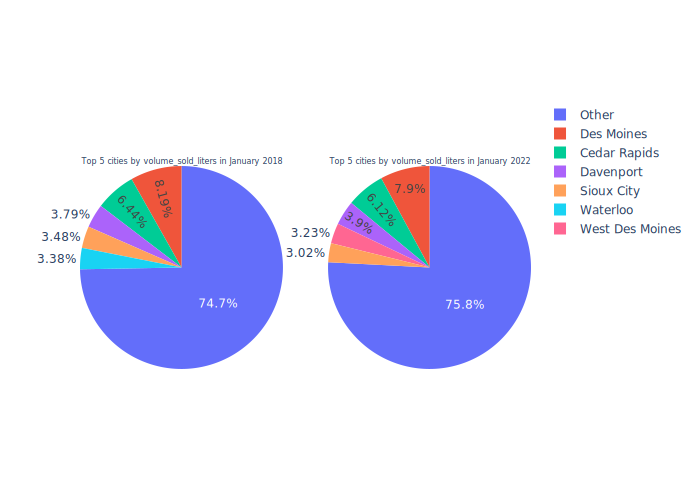

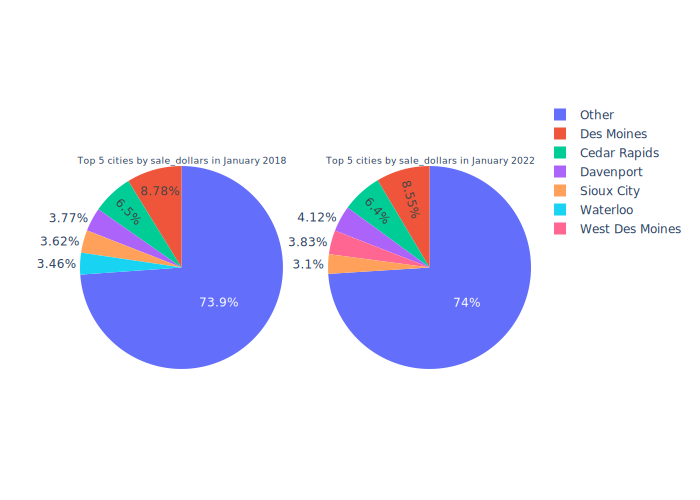

In [22]:
def visual_top_5_cities_by_volume_sold_liters_or_sale_dollars():
    for column in ["volume_sold_liters", "sale_dollars"]:
        fig = make_subplots(rows=1, cols=2,
                            specs=[[{"type": "pie"}, {"type": "pie"}]])

        for index, year in enumerate([2018, 2022]):
            dataframe = df6.loc[(df6['year'] == year) & (df6['month'] == 1)]
            series_other = dataframe.groupby('city')[column] \
                                    .sum() \
                                    .sort_values(ascending=False) \
                                    .index[5:]
            series = dataframe.replace(series_other, 'Other') \
                            .groupby('city')[column] \
                            .sum()
            fig.add_trace(go.Pie(values=series,
                                labels=series.index,
                                title="Top 5 cities by {0} in January {1}".format(column, year)),
                        row=1, col=index+1)
        
        fig.show()

visual_top_5_cities_by_volume_sold_liters_or_sale_dollars()

### 750 ml (Januari 2018 & 2022) adalah ukuran botol minuman beralkohol yang paling banyak terjual.

Dengan menyediakan ukuran botol minuman beralkohol 750ml, perusahaan dapat melayani 43.8% (Januari 2018) dan 44.3% (Januari 2022) pasar.

Untuk menciptakan "illusion of choice" dalam convenience store, perusahaan dapat menyediakan ukuran botol minuman beralkohol 750 ml, 1750 ml, 375 ml, 1000 ml untuk melayani 91.95% (2018) dan 89.23% (2022) pasar.

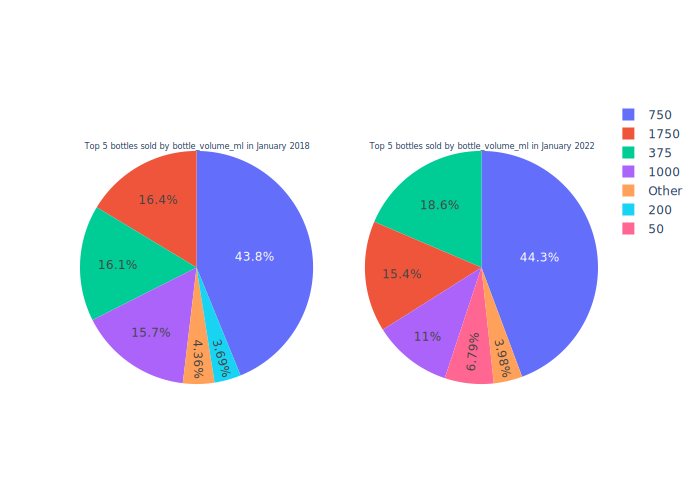

In [23]:
def visual_top_5_bottles_sold_by_bottle_volume_ml():
    for group in ['bottle_volume_ml']:
        fig = make_subplots(rows=1, cols=2,
                            specs=[[{"type": "pie"}, {"type": "pie"}]])
        for index, year in enumerate([2018, 2022]):
            # .copy() because we are going to change column type.
            dataframe = df6.loc[(df6['year'] == year) & (df6['month'] == 1)].copy()
            dataframe['bottle_volume_ml'] = dataframe[group].astype(str)

            series_other = dataframe.groupby(group)['bottles_sold'] \
                                    .sum() \
                                    .sort_values(ascending=False) \
                                    .index[5:]

            series = dataframe.replace(series_other, 'Other') \
                            .groupby(group)['bottles_sold'] \
                            .sum()
                            
            fig.add_trace(go.Pie(values=series,
                                labels=series.index,
                                title="Top 5 bottles sold by {0} in January {1}".format(group, year)),
                        row=1, col=index+1)

        fig.show()

visual_top_5_bottles_sold_by_bottle_volume_ml()

### American Vodkas (Januari 2018 & 22) adalah kategori minuman beralkohol paling banyak terjual.

Dengan hanya menyediakan kategori minuman beralkohol American Vodkas, perusahana dapat melayani 20.6% (2018) dan 20.3% (2022) pasar pada masing-masing tahun.

Untuk menciptakan "illusion of choice" dalam convenience store, perusahaan dapat menyediakan kategori minuman beralkohol American Vodkas, Canadian Whiskies, Spiced Rum, Straight Bourbon Whiskies, Whiskey Liquer untuk melayani 48.5% (Januari 2018) dan 49.2% (Januari 2022) pasar.

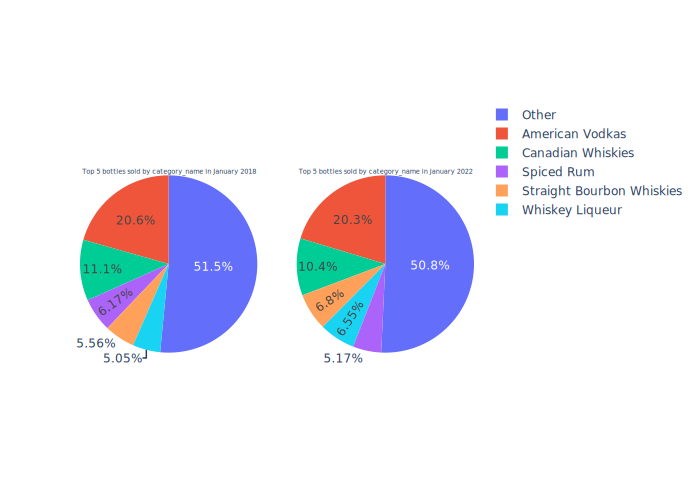

In [24]:
def visual_top_5_bottles_sold_by_category_name():
    for group in ['category_name']:
        fig = make_subplots(rows=1, cols=2,
                            specs=[[{"type": "pie"}, {"type": "pie"}]])
        for index, year in enumerate([2018, 2022]):
            # .copy() because we are going to change column type.
            dataframe = df6.loc[(df6['year'] == year) & (df6['month'] == 1)].copy()
            dataframe['bottle_volume_ml'] = dataframe[group].astype(str)

            series_other = dataframe.groupby(group)['bottles_sold'] \
                                    .sum() \
                                    .sort_values(ascending=False) \
                                    .index[5:]

            series = dataframe.replace(series_other, 'Other') \
                            .groupby(group)['bottles_sold'] \
                            .sum()
                            
            fig.add_trace(go.Pie(values=series,
                                labels=series.index,
                                title="Top 5 bottles sold by {0} in January {1}".format(group, year)),
                        row=1, col=index+1)

        fig.show()

visual_top_5_bottles_sold_by_category_name()

## Statistik Deskriptif

sub-bab sebelumnya termasuk Statistik Deskriptif. sub-bab ini dipisah untuk memudahkan penilaian sesuai assignment rubics.

### 6.15L (Januari 2018) dan 6.08L (Januari 2022) adalah rata-rata penjualan minuman beralkohol per transaksi di Iowa, Amerika Serikat.

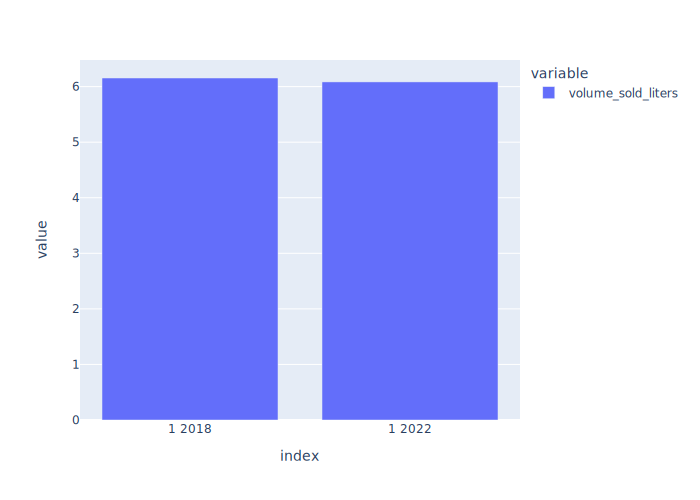

In [25]:
def visual_volume_sold_liters_mean():
    series = df6.groupby(['year', 'month'])['volume_sold_liters'].mean()
    series.index = ['{1} {0}'.format(i, j) for i, j in series.index]
    px.bar(series).show()

visual_volume_sold_liters_mean()

### \$89.26 (Januari 2018) dan \$106.83 (Januari 2022) adalah rata-rata penjualan minuman beralkohol per transaksi di Iowa, Amerika Serikat.

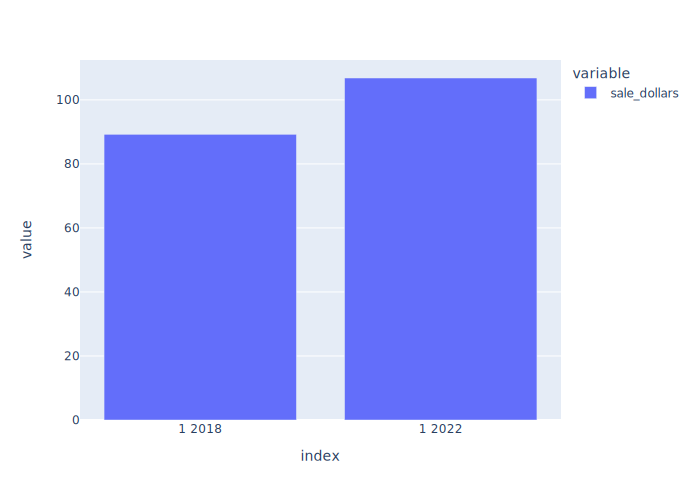

In [26]:
def visual_sale_dollars_mean():
    series = df6.groupby(['year', 'month'])['sale_dollars'].mean()
    series.index = ['{1} {0}'.format(i, j) for i, j in series.index]
    px.bar(series).show()

visual_sale_dollars_mean()

### \$16.04 million (Januari 2018) dan \$18.09 million (Januari 2022) adalah GMV minuman beralkohol.

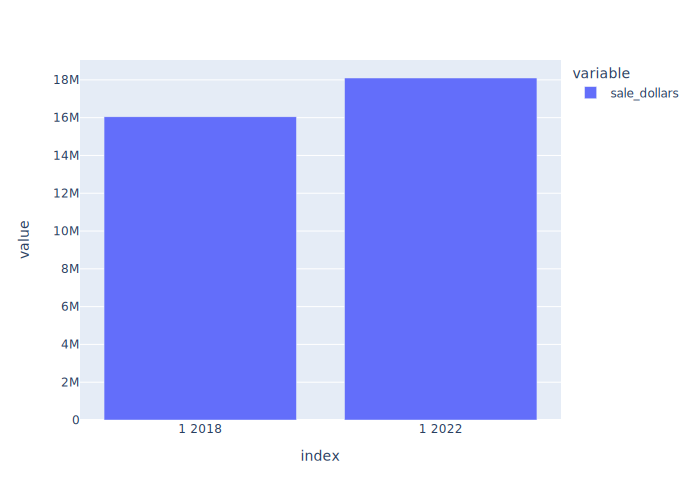

In [27]:
def visual_sale_dollars_sum():
    series = df6.groupby(['year', 'month'])['sale_dollars'].sum()
    series.index = ['{1} {0}'.format(i, j) for i, j in series.index]
    px.bar(series).show()

visual_sale_dollars_sum()

## Statistik Inferensial

Terdapat banyak faktor yang berbeda (hari libur, pandemi, dan lain-lain) dalam masing-masing data (2018 dan 2022). Faktor ini menyebabkan kita tidak dapat membandingkan kedua data secara adil.

Oleh karena itu, kita menggunakan hypothesis testing two sample untuk menguji apakah kedua data tersebut sama atau berbeda dari sisi:

1. rata-rata penjualan dalam volume, total harga pada bulan Januari 2018 dan 2021.
2. rata-rata harga minuman pada bulan Januari 2018 dan 2021.

### Rata-rata penjualan minuman beralkohol dalam volume pada bulan Januari 2018 dan 2022 berbeda.

H0: μ(2018, volume_sold_liters) = μ(2022, volume_sold_liters)

H1: μ(2018, volume_sold_liters) != μ(2022, volume_sold_liters)

We will reject null hypothesis if p-value is below 1%.

Since our p-value is less than 0.5%, so we reject the null hypothesis and we can conclude with 99% confidence that, the average sales in terms of volume sold liters in January 2018 and January 2022 is different.

In [28]:
def hypothesis_testing_two_sample_volume_sold_liters_unequal():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1),'volume_sold_liters']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1),'volume_sold_liters']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022)
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_volume_sold_liters_unequal()

p-value 0.00


#### Rata-rata penjualan minuman beralkohol dalam volume pada bulan Januari 2018 lebih besar daripada Januari 2022

H0: μ(2018, volume_sold_liters) >= μ(2022, volume_sold_liters)

H1: μ(2018, volume_sold_liters) < μ(2022, volume_sold_liters)

We will reject null hypothesis if p-value is below 0.5%.

Based on the result below, we can conclude with 99% confidence that we fail to reject the null hypothesis which means the average sales in terms of volume sold liters in January 2018 is more than equal compared to January 2022.

In [29]:
def hypothesis_testing_two_sample_volume_sold_liters_less():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1),'volume_sold_liters']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1),'volume_sold_liters']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022, alternative="less")
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_volume_sold_liters_less()

p-value 1.00


### Rata-rata penjualan minuman beralkohol per transaksi pada bulan Januari 2018 dan 2022 berbeda

H0: μ(2018, sale_dollars) = μ(2022, sale_dollars)

H1: μ(2018, sale_dollars) != μ(2022, sale_dollars)

We will reject null hypothesis if p-value is below 0.5%.

Since our p-value is less than 0.5%, so we reject the null hypothesis and we can conclude with 99% confidence that, the average sales in terms of dollars in January 2018 and January 2022 is different.

In [30]:
def hypothesis_testing_two_sample_sale_dollars_unequal():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1),'sale_dollars']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1),'sale_dollars']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022)
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_sale_dollars_unequal()

p-value 0.00


#### Rata-rata penjualan minuman beralkohol per transaksi pada bulan Januari 2018 lebih kecil daripada 2022.

H0: μ(2018, sale_dollars) <= μ(2022, sale_dollars)

H1: μ(2018, sale_dollars) > μ(2022, sale_dollars)

We will reject null hypothesis if p-value is below 0.5%.

Based on the result below, we can conclude with 99% confidence that we fail to reject the null hypothesis which means the average sales in terms of dollars in January 2018 is less than equal compared to January 2022.

In [31]:
def hypothesis_testing_two_sample_sale_dollars_greater():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1),'sale_dollars']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1),'sale_dollars']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022, alternative="greater")
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_sale_dollars_greater()

p-value 1.00


### Rata-rata harga minuman beralkohol pada bulan Januari 2018 dan 2022 berbeda

H0: μ(2018, state_bottle_retail) = μ(2022, state_bottle_retail)

H1: μ(2018, state_bottle_retail) != μ(2022, state_bottle_retail)

We will reject null hypothesis if p-value is below 1%.

Since our p-value is less than 1%, so we reject the null hypothesis and we can conclude with 99% confidence that, the average bottle retail price in January 2018 and January 2022 is different.

In [32]:
def hypothesis_testing_two_sample_state_bottle_retail_unequal():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1), 'state_bottle_retail']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1), 'state_bottle_retail']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022)
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_state_bottle_retail_unequal()

p-value 0.00


#### Rata-rata harga minuman beralkohol pada bulan Januari 2018 lebih rendah daripada 2022

H0: μ(2018, state_bottle_retail) >= μ(2022, state_bottle_retail)

H1: μ(2018, state_bottle_retail) < μ(2022, state_bottle_retail)

We will reject null hypothesis if p-value is below 0.5%.

Since our p-value is less than 0.5, so we reject the null hypothesis and we can conclude with 99% confidence that, the average bottle retail price in January 2018 is less than equal compared to January 2022.

In [33]:
def hypothesis_testing_two_sample_state_bottle_retail_less():
    series_1_2018 = df6.loc[(df6['year'] == 2018) & (df6['month'] == 1), 'state_bottle_retail']
    series_1_2022 = df6.loc[(df6['year'] == 2022) & (df6['month'] == 1), 'state_bottle_retail']

    t_stat, p_val = stats.ttest_ind(series_1_2018, series_1_2022, alternative='less')
    print("p-value {:.2f}".format(p_val))

hypothesis_testing_two_sample_state_bottle_retail_unequal()

p-value 0.00


# Pengambilan Keputusan

## The Insights

1. Des Mones adalah kota dengan penjualan tertinggi minuman beralkohol di Iowa, Amerika Serikat pada bulan Januari 2018 dan 2022
2. 750 ml (2018, 2022) adalah ukuran botol minuman beralkohol yang paling banyak terjual pada masing-masing tahun.
   1. 91.95% (Januari 2018) dan 89.23% (Januari 2022) pasar dapat dilayani dengan hanya menyediakan ukuran botol minuman beralkohol 750 ml, 1750 ml, 375 ml, dan 1000 ml.
3. American Vodkas (Januari 2018 & 2022) adalah kategori minuman beralkohol yang paling banyak terjual.
   1. 48.5% (Januari 2018) dan 49.2% (Januari 2022) pasar dapat dilayani dengan hanya 5 kategori minuman, yaitu American Vodkas, Canadian Whiskies, Spiced Rum, Straight Bourbon Whiskies, dan Whiskey Liquer.
4. 6.15L (Januari 2018) dan 6.08L (Januari 2022) adalah rata-rata penjualan minuman beralkohol per transaksi di Iowa, Amerika Serikat (teruji dengan hypothesis testing two sample independent).
5. \$89.26 (Januari 2018) dan \$106.83 (Januari 2022) adalah rata-rata penjualan minuman beralkohol per transaksi di Iowa, Amerika Serikat (teruji dengan hypothesis testing two sample independent).
6. \$16.04 million (Januari 2018) dan \$18.09 million (Januari 2022) adalah GMV minuman beralkohol di Iowa, Amerika Serikat.
7. Rata-rata harga minuman beralkohol pada bulan Januari 2018 lebih rendah daripada 2022 di Iowa, Amerika Serikat (teruji dengan hypothesis testing two sample independent).

## Benang merah

Seandainya terjadi krisis, perusahaan tidak perlu khawatir terjadi perubahan permintaan dalam pasar. Baik pangsa pasar yang dilayani per kota (Top 1-3), per ukuran botol (Top 1-5), per kategori minuman beralkohol (Top 1-5) tidak berubah. Bahkan, rata-rata nilai transaksi meningkat pada puncak krisis.

Selain itu, jika keadaan mengharuskan perusahaan melakukan downsizing inventory, hanya dengan fokus pada Top 1-5 ukuran botol, Top 1-5 kategori minuman beralkohol, perusahaan dapat melayani 43% pasar (Januari 2022).

## Rekomendasi

Jika perusahaan mengikuti rekomendasi Data Analyst, maka perusahaan dapat melayani pasar dengan nilai sebesar \$679,000 pada bulan Januari 2022.

Nilai pasar dihitung sebagai berikut:
```
GMV minuman beralkohol di Iowa, Amerika Serikat 
* pangsa pasar yang dilayani, yaitu kota Des Moines 
* pangsa pasar yang dilayani berdasarkan ukuran botol minuman beralkohol 
* pangsa pasar yang dilayani berdasarkan kategori minuman beralkohol
```

Rekomendasi Data Analyst adalah sebagai berikut:

Disclaimer: perusahaan membuka toko pada tahun 2022 (bukan tahun 2023, prediksi bukan scope dari Data Analyst saat ini)

1. Kota yang perusahaan harus pilih adalah Des Moines jika ingin berada pada 8.55% pasar.
2. Ukuran botol minuman beralkohol yang harus disediakan perusahaan adalah 750 ml, 1750 ml, 375 ml dan 1000 ml jika ingin melayani 89.23% pasar.
3. Kategori minuman beralkohol yang harus disediakan perusahaan adalah American Vodkas, Canadian Whiskies, Spiced Rum, Straight Bourbon Whiskies, dan Whiskey Liquer jika ingin melayani 49.2% pasar.
4. Promo yang harus dijalankan untuk menarik pelanggan dari kompetitor adalah "Min. Belanja \$100" atau "Min. Volume 6 Liter"